# Consignas

1)Desarrollar un sistema de recomendación de prestadores a partir de un modelo K-Nearest Neighbours.

Teniendo en cuenta que el perfil de los pacientes en cada especialidad muestra una marcada diferencia, desarrollar un modelo de recomendación para cada especialidad.
Utilizar modelo sklearn.neighbors.KNeighborsClassifier. La variable target será el id_prestador.
En línea con el objetivo planteado para el proyecto, el dataset de entrenamiento y validación del modelo serán aquellos prestadores que muestran altas calificaciones y un nivel de demanda medio y alto. Las altas calificaciones nos aseguran que los prestadores a recomendar brindan un buen servicio. El nivel de demanda medio/alto nos asegura que las calificaciones son representativas estadísticamente.


# Importación de librerías

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import ptitprince as pt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV ,  train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
import operator
import scipy as sp

pd.options.display.float_format = "{:,.4f}".format

# Importación de datasets

In [2]:
df_procesado=pd.read_csv('../Data/df_procesado.csv')
df_procesado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 31 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   id_consumo_encoded                                                                 2500 non-null   int64  
 1   id_socio_encoded                                                                   2500 non-null   int64  
 2   id_prestador_encoded                                                               2500 non-null   int64  
 3   calificacion_experiencia_encoded                                                   2500 non-null   float64
 4   id_zona_encoded                                                                    2500 non-null   int64  
 5   edad_encoded                                                                       2500 non-null   float

In [3]:
df_procesado.head(2)

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,especialidad_prestador_encoded_CLINICA MEDICA,especialidad_prestador_encoded_NUTRICIONISTAS(LIC.),especialidad_prestador_encoded_PEDIATRIA,edad_cat_pediatrico,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard
0,1,100000,200000,0.667,1,0.953,0.531,1,0,1,...,1,0,0,1,1,0,0,0,0,1
1,2,100000,200000,0.556,1,0.953,0.531,1,0,1,...,1,0,0,1,1,0,0,0,0,1


### Análisis de demanda de prestadores

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


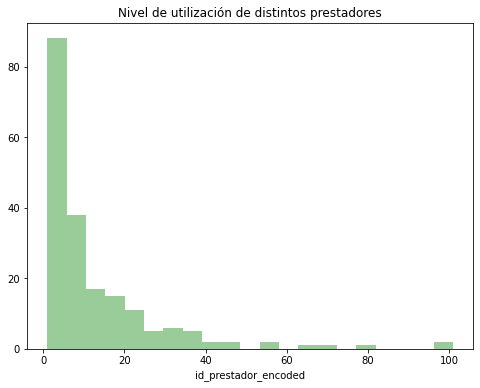

In [4]:
plt.figure(figsize=(8,6))
sns.distplot(df_procesado.id_prestador_encoded.value_counts(),kde=False,color='g')
plt.title("Nivel de utilización de distintos prestadores")
plt.show()

Partiendo del análisis realizado en los laboratorios anteriores, tenemos muchos prestadores que han sido utilizados pocas veces, mientras que hay pocos que han sido utilizados muchas veces.
Vamos a hacer una selección basándonos en medidas de tendencia central de la distribución anterior

In [5]:
df_procesado.id_prestador_encoded.value_counts().describe().reset_index()

,index,id_prestador_encoded
0,count,196.000
1,mean,12.755
2,std,16.325
3,min,1.000
4,25%,3.000
5,50%,7.000
6,75%,17.000
7,max,101.000


Vamos a filtrar utilizando el percentil 0.42

In [8]:
percetil_42=df_procesado.id_prestador_encoded.value_counts().quantile(0.42)
clientes_filtrados=df_procesado.id_prestador_encoded.value_counts()[df_procesado.id_prestador_encoded.value_counts()>percetil_42].index

In [9]:
df_procesado=df_procesado[df_procesado.id_prestador_encoded.isin(clientes_filtrados)]
df_procesado.shape

(2272, 31)

### Análisis de calificaciones

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


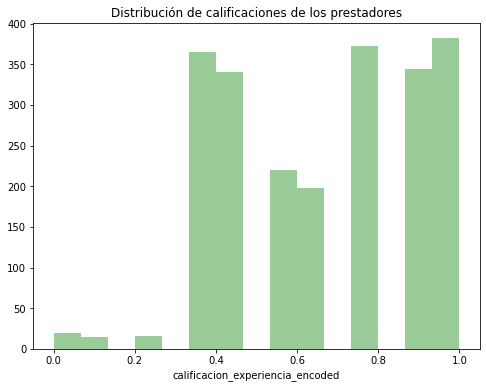

In [10]:
plt.figure(figsize=(8,6))
sns.distplot(df_procesado.calificacion_experiencia_encoded,kde=False,color='g')
plt.title("Distribución de calificaciones de los prestadores")
plt.show()

In [11]:
df_procesado.calificacion_experiencia_encoded.describe().reset_index()

,index,calificacion_experiencia_encoded
0,count,"2,272.000"
1,mean,0.665
2,std,0.249
3,min,0.000
4,25%,0.444
5,50%,0.667
6,75%,0.889
7,max,1.000


Vamos a filtrar utilizando el percentil 0.405

In [12]:
percentil_0405=df_procesado.calificacion_experiencia_encoded.quantile(0.405)

In [13]:
df_filtrado=df_procesado[df_procesado.calificacion_experiencia_encoded>percentil_0405]

In [14]:
df_filtrado.shape

(1297, 31)

## Especialidad Clínica Médica

Filtramos los prestadores según la categoría estándar para simplificar el análisis

In [15]:
columns=['id_socio_encoded','id_prestador_encoded','calificacion_experiencia_encoded',]
df_filtrado = df_filtrado[(df_filtrado['especialidad_prestador_encoded_CLINICA MEDICA']==1)]
df_filtrado=df_filtrado[columns]

In [16]:
df_filtrado

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded
0,100000,200000,0.667
2,100002,200000,0.667
3,100010,200000,0.667
4,100017,200000,0.667
7,100035,200000,0.667
...,...,...,...
2256,101492,200129,1.000
2257,101682,200129,0.889
2258,101696,200129,0.889
2259,101710,200129,0.778


Tenemos varias calificaciones de un mismo socio para el mismo prestador, por lo cual calculamos el promedio de todas ellas.

In [17]:
df_filtrado[(df_filtrado.id_socio_encoded==100582    )]

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded
784,100582,200029,0.889
785,100582,200029,0.778
786,100582,200029,0.889
787,100582,200029,0.889
788,100582,200029,0.778


In [18]:
df_sr=df_filtrado.groupby(['id_socio_encoded','id_prestador_encoded'])['calificacion_experiencia_encoded'].mean().reset_index()
df_sr.head()

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded
0,100000,200000,0.667
1,100001,200001,0.778
2,100002,200000,0.667
3,100003,200002,0.889
4,100006,200001,0.889


In [19]:
df_sr[(df_sr.id_socio_encoded==100582    )]

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded
142,100582,200029,0.844


In [20]:
df_sr.shape

(482, 3)

In [21]:
df_pivot = df_sr.pivot_table(columns='id_socio_encoded', index='id_prestador_encoded', values="calificacion_experiencia_encoded")
df_pivot.fillna(0, inplace=True)

In [22]:
df_pivot

id_socio_encoded,100000,100001,100002,100003,100006,100007,100010,100011,100012,100013,...,101853,101882,101884,101885,101893,101902,101906,101909,101910,101919
id_prestador_encoded,,,,,,,,,,,,,,,,,,,,,
200000,0.667,0.000,0.667,0.000,0.000,0.000,0.667,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
200001,0.000,0.778,0.000,0.000,0.889,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
200002,0.000,0.000,0.000,0.889,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
200005,0.000,0.000,0.000,0.000,0.000,0.667,0.000,0.000,0.667,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
200008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.778,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
200009,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.667,...,0.000,0.000,0.667,0.000,0.000,0.000,0.000,0.000,0.000,0.000
200010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.889,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
200021,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.778,0.889,0.000,0.000,0.000,0.000,0.000
200028,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.778,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000


## K vecinos mas cercanos

In [53]:
piv_sparse = sp.sparse.csr_matrix(df_pivot.values)

In [54]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(algorithm='brute')
model.fit(piv_sparse)

NearestNeighbors(algorithm='brute')

In [56]:
distancias, sugerencias = model.kneighbors(df_pivot.loc[200001, :].values.reshape(1, -1))

In [58]:
for i in range(len(sugerencias)):
  print(df_pivot.index[sugerencias[i]])

Int64Index([200001, 200000, 200038, 200071, 200129], dtype='int64', name='id_prestador_encoded')


In [59]:
distancias

array([[5.96046448e-08, 5.88521898e+00, 5.88521898e+00, 5.91349970e+00,
        5.98325854e+00]])

In [60]:
sugerencias

array([[ 1,  0, 11, 14, 16]], dtype=int64)

## Similaridad del coseno

In [43]:
piv_sparse = sp.sparse.csr_matrix(df_pivot.values)

In [44]:
prestador_similarity = cosine_similarity(piv_sparse)
usuario_similarity = cosine_similarity(piv_sparse.T)

In [45]:
prestadores_sim_df = pd.DataFrame(prestador_similarity, index = df_pivot.index, columns = df_pivot.index)
usuarios_sim_df = pd.DataFrame(usuario_similarity, index = df_pivot.columns, columns = df_pivot.columns)

In [46]:
usuarios_sim_df

id_socio_encoded,100000,100001,100002,100003,100006,100007,100010,100011,100012,100013,...,101853,101882,101884,101885,101893,101902,101906,101909,101910,101919
id_socio_encoded,,,,,,,,,,,,,,,,,,,,,
100000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
100001,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
100002,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
100003,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
100006,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101902,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
101906,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
101909,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


In [47]:
prestadores_sim_df

id_prestador_encoded,200000,200001,200002,200005,200008,200009,200010,200021,200028,200029,200035,200038,200042,200046,200071,200097,200129
id_prestador_encoded,,,,,,,,,,,,,,,,,
200000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200001,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200002,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200005,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200008,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200009,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200010,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200021,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200028,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [48]:
def top_prestadores(prestador):
    count = 1
    print('Prestadores similares al {} :\n'.format(prestador))
    for item in prestadores_sim_df.sort_values(by = prestador, ascending = False).index[1:11]:
        print('No. {}: {}'.format(count, item))
        count +=1  

In [42]:
top_prestadores(200001)

Prestadores similares al 200001 :

No. 1: 200000
No. 2: 200029
No. 3: 200097
No. 4: 200071
No. 5: 200046
No. 6: 200042
No. 7: 200038
No. 8: 200035
No. 9: 200028
No. 10: 200021


In [51]:
def usuarios_similares_prestadores(usuario):
    
    usuarios_similares = usuarios_sim_df.sort_values(by=usuario, ascending=False).index[1:11]
    best = []
    most_common = {}
    
    for i in usuarios_similares:
        max_score = df_pivot.loc[:, i].max()
        best.append(df_pivot[df_pivot.loc[:, i]==max_score].index.tolist())
        
    for i in range(len(best)):
        for j in best[i]:
            if j in most_common:
                most_common[j] += 1
            else:
                most_common[j] = 1
                
    sorted_list = sorted(most_common.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_list[:5] 

In [52]:
usuarios_similares_prestadores(100002)

[(200000, 10)]